In [31]:
options(repr.plot.width=8, repr.plot.height=6, repr.plot.res = 180)

In [91]:
library(tidyverse)
library(cowplot)
library(ggrepel)
library(stats)

In [9]:
#########  PART 0. Data Prep  #########
setwd("/Users/chaodai/qBio/BSD-QBio6/tutorials/data_visualization")

In [22]:
# read in pheno
source(c("readpheno.R"))

# read in hmdp
hmdp = read_csv("hmdp.csv")

# gwscan
gwscan = read_csv('gwscan.csv') %>%
    mutate_at('chr', ~factor(.x, levels = 1:19))

# geno
geno = read_csv("geno_rs29477109.csv", col_types = cols(id = 'c', dosage = 'd'))

## Part A. Exploratory

### 1. Eistribution of tibialis anterior (TA)

TA weight distribution is roughly normal, there are some outliers, particularly in the lower end. 

Warning message:
“Removed 29 rows containing non-finite values (stat_bin).”


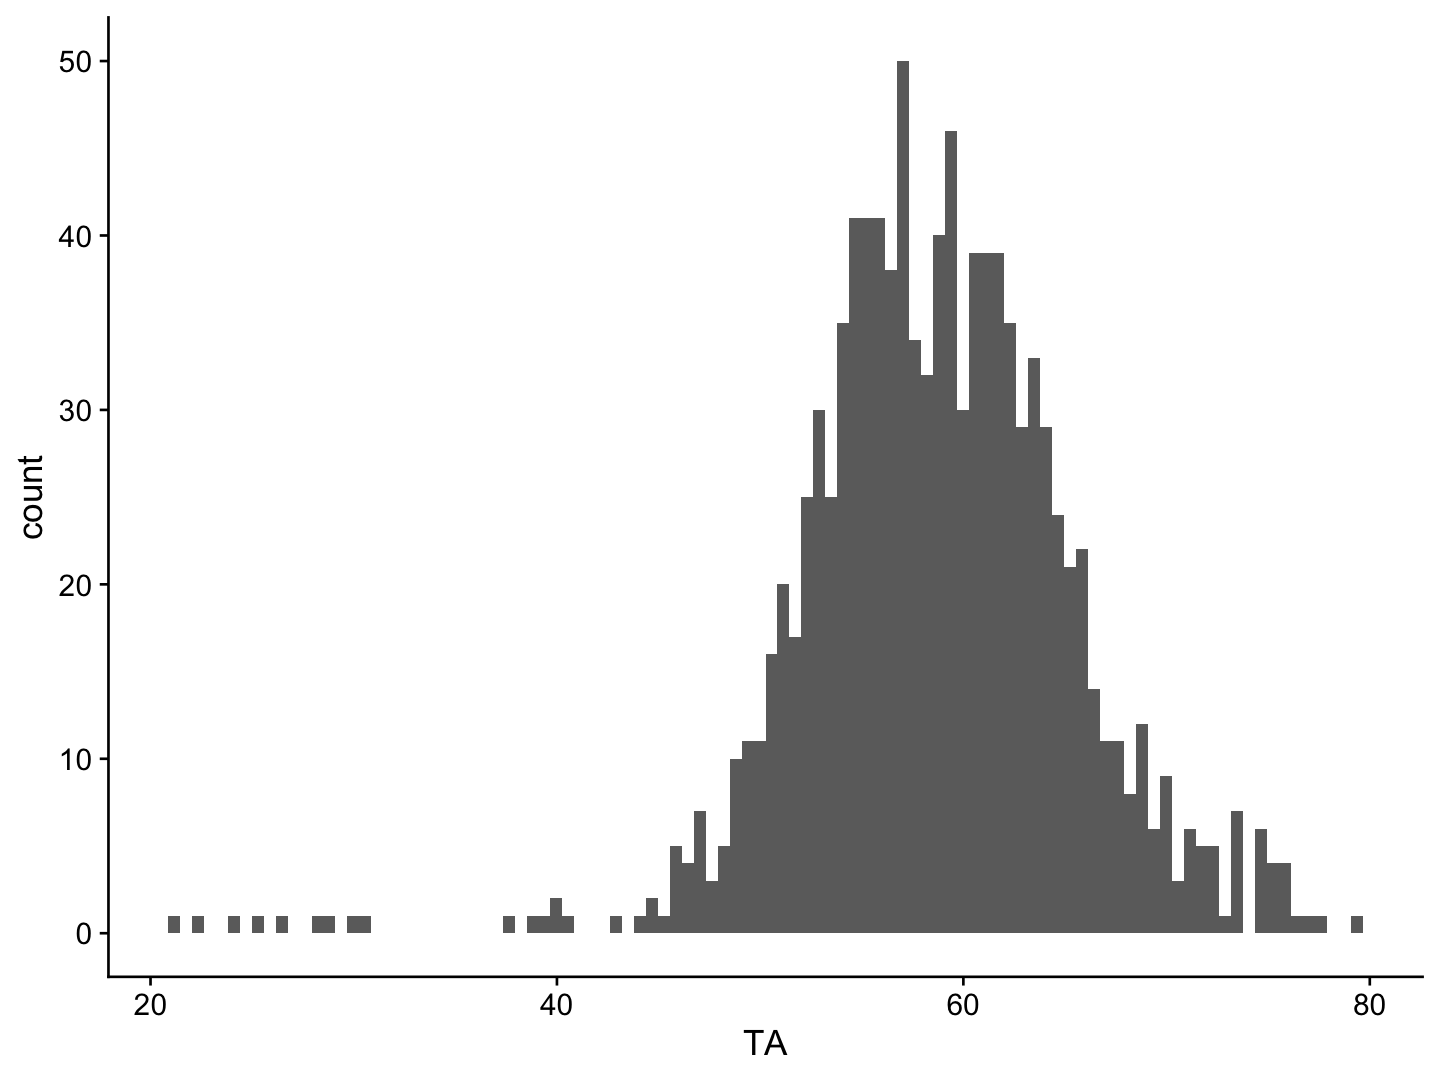

In [37]:
ggplot(pheno) + geom_histogram(aes(TA), bins = 100, alpha = .9) +
    theme_cowplot()

#### set cutoffs as standard outlier criteria [1st Q - 1.5 IQR, 3rd q + 1.5 IQR] 

Based on this criteria, there are 28 outliers

In [120]:
TA.cutoffs = quantile(pheno$TA, na.rm = T, probs = c(.25, .75)) + c(-1.5, 1.5) * IQR(pheno$TA, na.rm = T)

In [124]:
filter(pheno, TA < TA.cutoffs[1] | TA > TA.cutoffs[2]) %>% pull(TA) %>% sort %>% length

[1] 28

## 2. `tibia` vs. `TA`

Tibia bone weight is positively correlated with TA muscle weight. 

### Before removing outliers

In [43]:
lm.tibia_ta = lm(tibia ~ TA, pheno)

In [44]:
summary(lm.tibia_ta)


Call:
lm(formula = tibia ~ TA, data = pheno)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.4694 -0.2690  0.0087  0.2681  1.4018 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 16.897321   0.110263  153.25   <2e-16 ***
TA           0.025527   0.001866   13.68   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4143 on 1055 degrees of freedom
  (35 observations deleted due to missingness)
Multiple R-squared:  0.1507,	Adjusted R-squared:  0.1499 
F-statistic: 187.2 on 1 and 1055 DF,  p-value: < 2.2e-16


In [45]:
coef(lm.tibia_ta)

(Intercept)          TA 
16.89732142  0.02552682

Warning message:
“Removed 35 rows containing missing values (geom_point).”


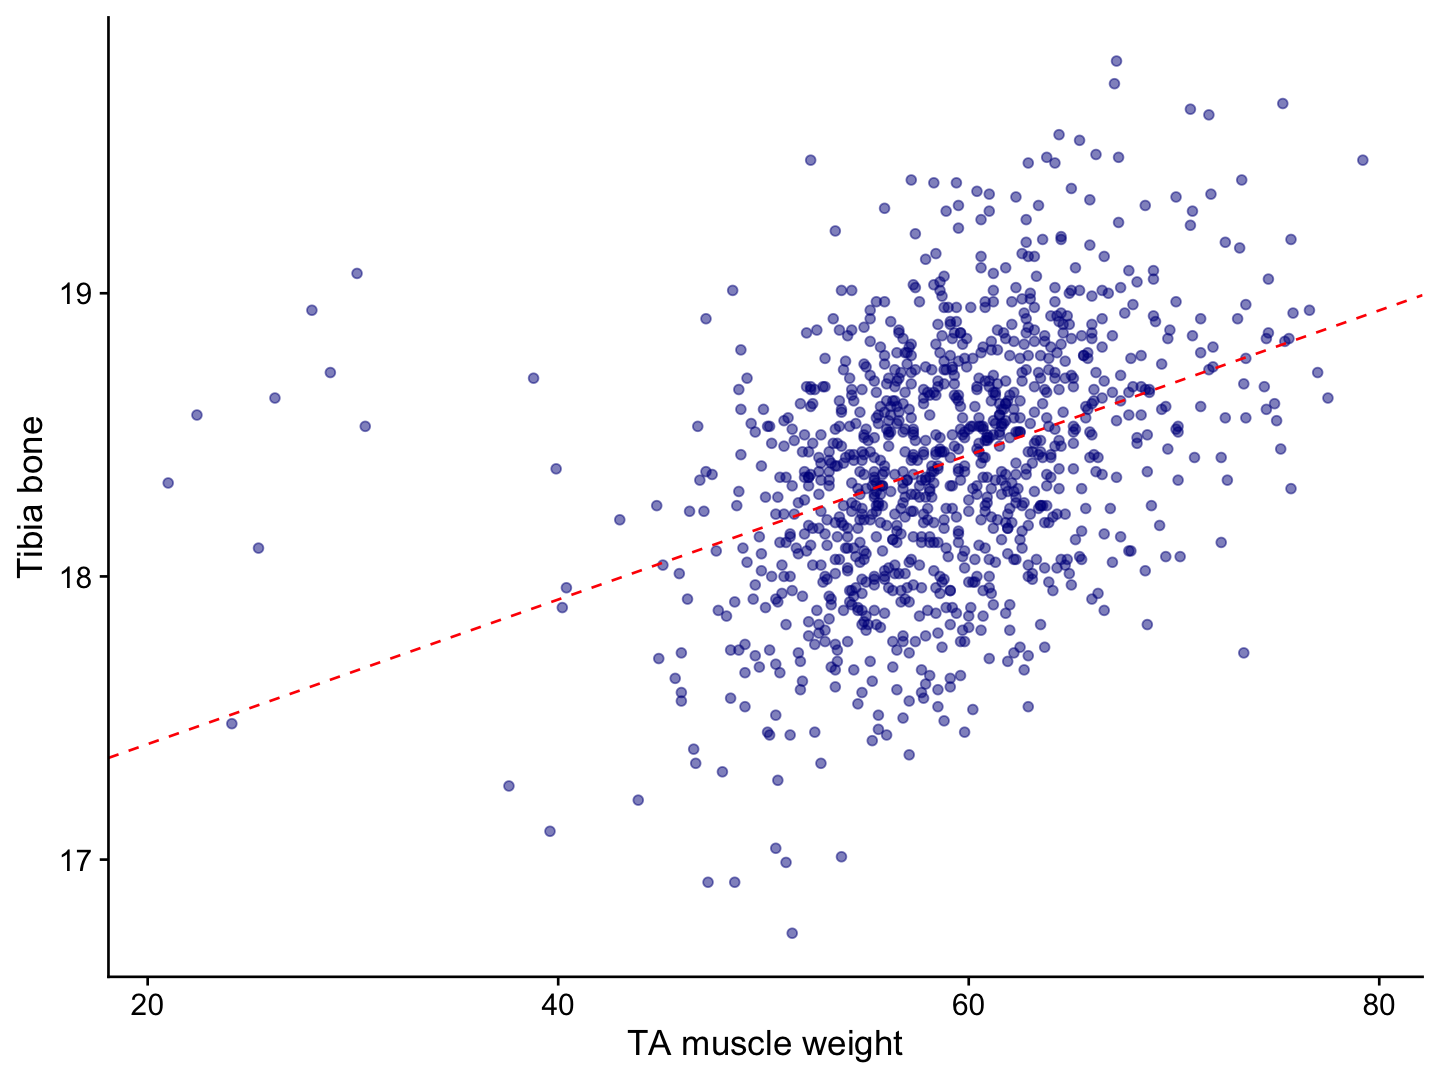

In [69]:
ggplot(pheno) + geom_point(aes(TA, tibia), alpha = .5, color = 'darkblue') +
    geom_abline(slope = coef(lm.tibia_ta)[2], intercept = coef(lm.tibia_ta)[1], color = 'red', linetype = 'dashed') +
    theme_cowplot() +
    labs(x = "TA muscle weight", y = 'Tibia bone')

### After removing outliers, set outliers at `40`. 

In [135]:
pheno.ro = filter(pheno, TA >= TA.cutoffs[1] & TA <= TA.cutoffs[2]) # remove outlier

In [136]:
lm.tibia_ta.ro = lm(tibia ~ TA, pheno.ro)

In [137]:
summary(lm.tibia_ta.ro)


Call:
lm(formula = tibia ~ TA, data = pheno.ro)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.4044 -0.2766  0.0047  0.2780  1.2958 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 16.441191   0.129941  126.53   <2e-16 ***
TA           0.033136   0.002197   15.08   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4025 on 1027 degrees of freedom
  (6 observations deleted due to missingness)
Multiple R-squared:  0.1814,	Adjusted R-squared:  0.1806 
F-statistic: 227.5 on 1 and 1027 DF,  p-value: < 2.2e-16


In [138]:
coef(lm.tibia_ta.ro)

(Intercept)          TA 
16.44119084  0.03313643

Warning message:
“Removed 6 rows containing missing values (geom_point).”


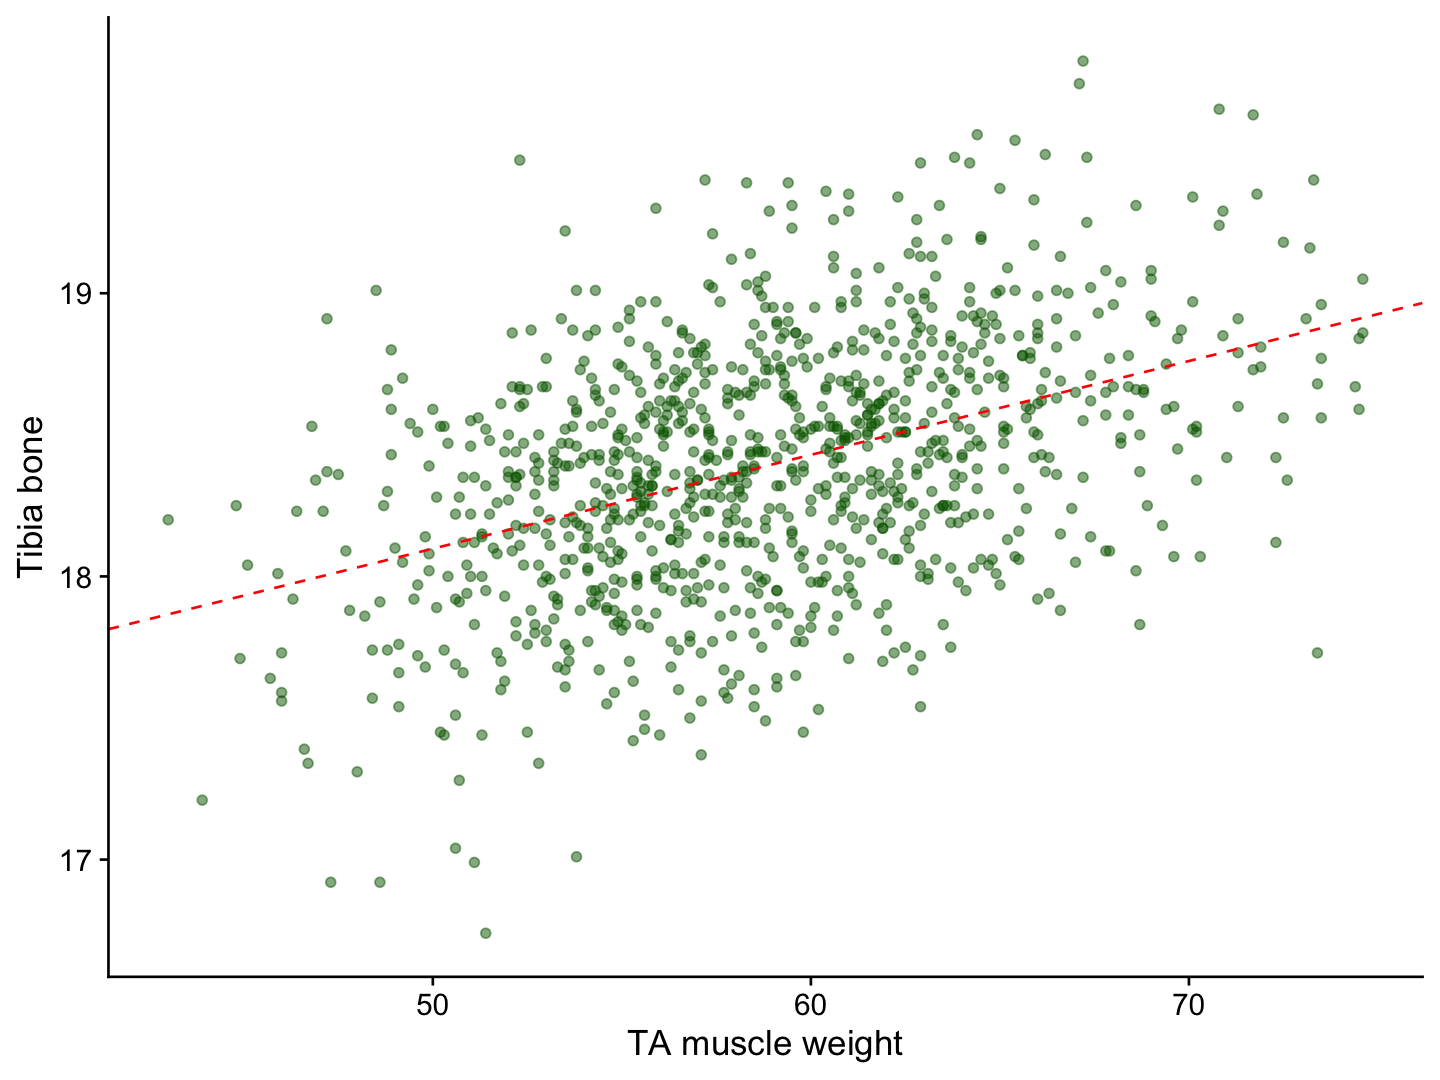

In [139]:
ggplot(pheno.ro) + geom_point(aes(TA, tibia), alpha = .5, color = 'darkgreen') +
    geom_abline(slope = coef(lm.tibia_ta.ro)[2], intercept = coef(lm.tibia_ta.ro)[1], color = 'red', linetype = 'dashed') +
    theme_cowplot() +
    labs(x = "TA muscle weight", y = 'Tibia bone')

### 3. Conditioned Fear test `AvToneD3`

#### Distribution of `AvToneD3`, before logit transformation

The distribution is not a normal distribution

Warning message:
“Removed 62 rows containing non-finite values (stat_bin).”


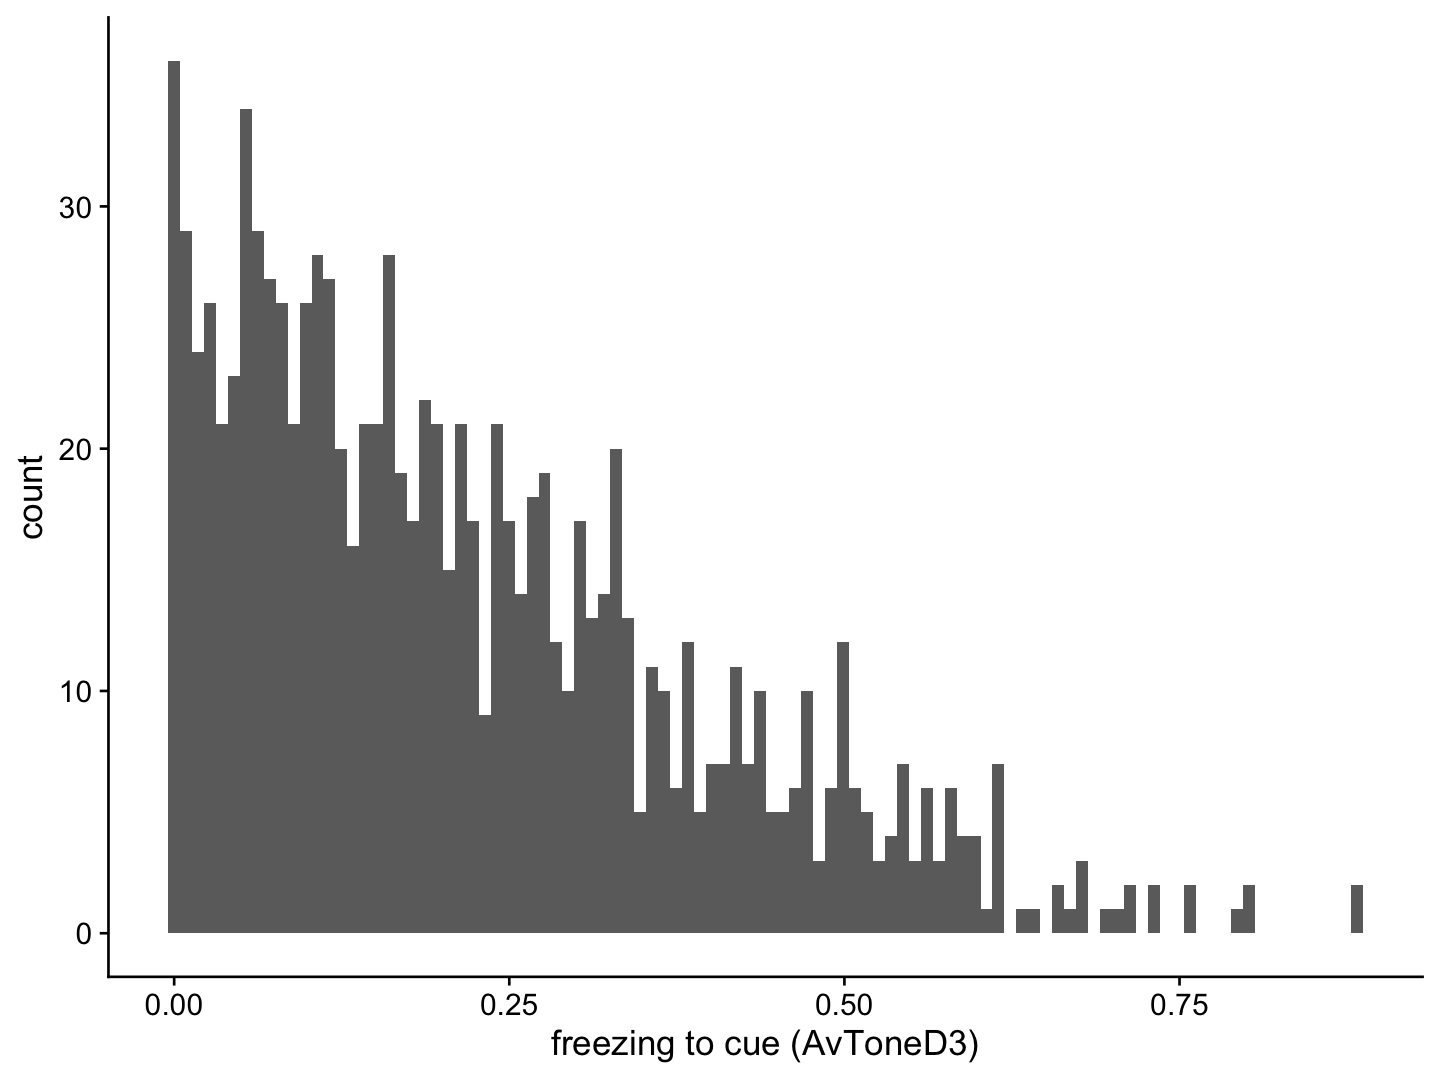

In [142]:
ggplot(pheno) + geom_histogram(aes(AvToneD3), bins = 100, alpha = .9) +
    theme_cowplot() +
    labs(x = 'freezing to cue (AvToneD3)')
    

In [143]:
logit = function(x) {
    log((x + .001) / (1 - x + .001))
}

Logit transformed `AvToneD3` is more normal like. There are some unusually small values (small negatives)

Warning message:
“Removed 62 rows containing non-finite values (stat_bin).”


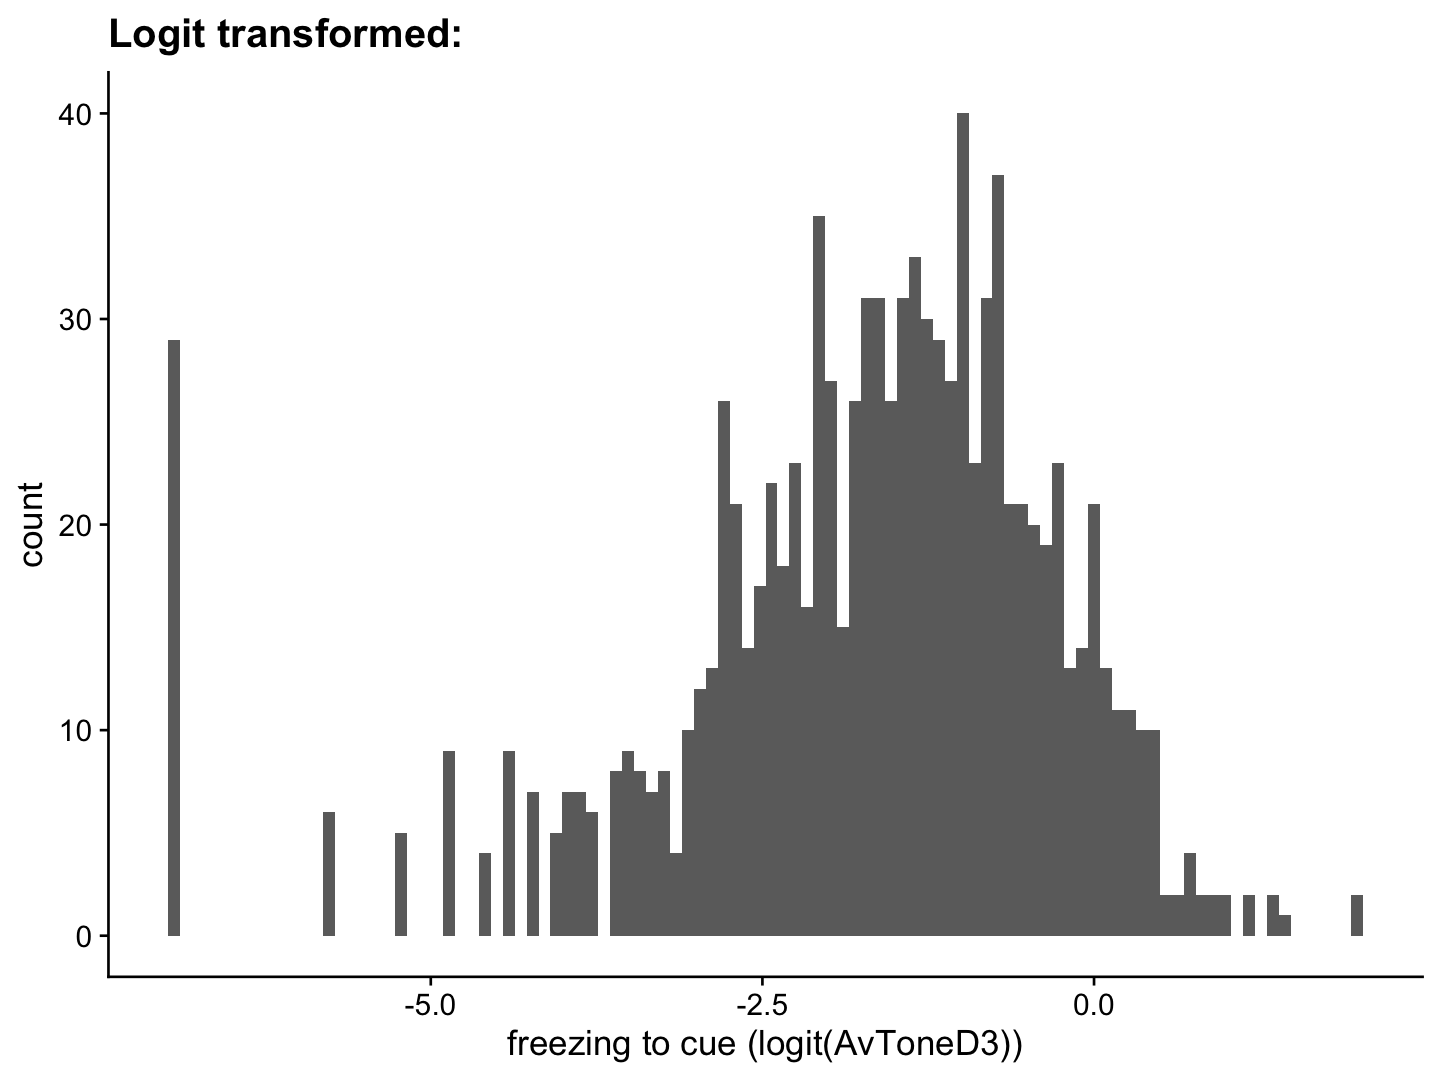

In [146]:
ggplot(pheno) + geom_histogram(aes(logit(AvToneD3)), bins = 100, alpha = .9) +
    theme_cowplot() +
    labs(x = 'freezing to cue (logit(AvToneD3))', title = 'Logit transformed:')

Boxplot: `AvToneD3` by `FCbox`

Warning message:
“Removed 62 rows containing non-finite values (stat_bin).”


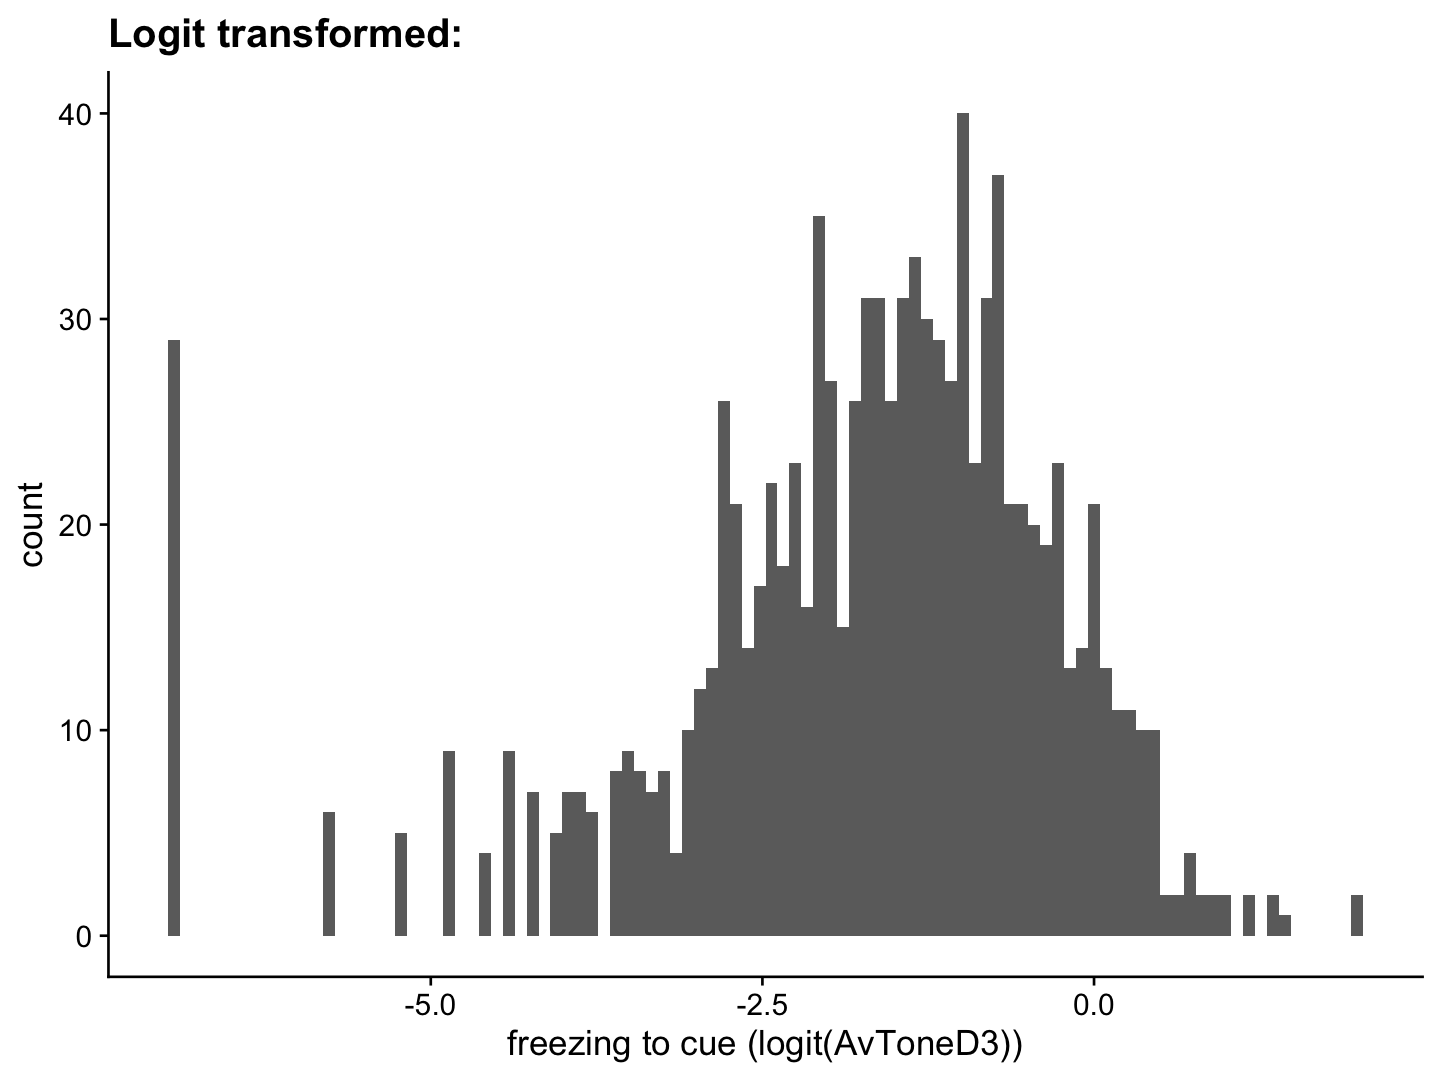

In [146]:
ggplot(pheno) + geom_boxplot(aes(x = , y = logit(AvToneD3)), bins = 100, alpha = .9) +
    theme_cowplot() +
    labs(x = 'freezing to cue (logit(AvToneD3))', title = 'Logit transformed:')

In [51]:
str(pheno.ro)

'data.frame':	1050 obs. of  41 variables:
 $ id            : chr  "26305" "26306" "26307" "26308" ...
 $ round         : Factor w/ 25 levels "SW1","SW2","SW3",..: 18 18 18 18 18 18 18 18 18 18 ...
 $ cageid        : int  1330002 1330002 1330002 1330002 1330003 1330003 1330003 1330004 1330004 1330004 ...
 $ FCbox         : Factor w/ 4 levels "1","2","3","4": 1 2 3 4 1 2 4 1 3 4 ...
 $ PPIbox        : Factor w/ 5 levels "1","2","3","4",..: 1 3 4 5 1 3 5 1 4 5 ...
 $ methcage      : Factor w/ 12 levels "1","2","3","4",..: 1 2 3 4 5 6 8 9 11 12 ...
 $ methcycle     : Factor w/ 4 levels "1","2","3","4": 1 1 1 1 1 1 1 1 1 1 ...
 $ discard       : Factor w/ 2 levels "no","yes": 1 1 1 1 1 1 1 1 1 1 ...
 $ mixup         : Factor w/ 2 levels "no","yes": 1 1 1 1 1 1 1 1 1 1 ...
 $ earpunch      : Factor w/ 2 levels "L","R": 2 2 1 1 2 2 1 2 1 1 ...
 $ glucoseage    : int  46 46 46 46 46 46 46 46 46 46 ...
 $ methage       : int  54 54 54 54 54 54 54 54 54 54 ...
 $ FCage         : int  62 62 62 62

---

In [93]:
?IQR


IQR {stats},R Documentation
x,a numeric vector.
na.rm,logical. Should missing values be removed?
type,"an integer selecting one of the many quantile algorithms, see quantile."
